## 0. 환경 설정하기

#### 1) 구글 드라이브 연결하기

In [1]:
# 코랩 사용 시 구글 드라이브 연결
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### 2) 경로 확인하기

In [2]:
# ROOT_PATH 확인 
import os

# 구글 드라이브 내 프로젝트 압축해제된 영역 (구글 드라이브 최상위에 압축해제 시 그대로 실행 수정 X)
WORK_SPACE = "Colab Notebooks"

if os.getcwd() == '/content' :
  # 구글 드라이브 사용 시 
  ROOT_PATH = "/content/drive/MyDrive/"+WORK_SPACE+"/AIVLE3rd_individual"
else :
  ROOT_PATH = os.path.abspath('..')
# Train 데이터 셋 경로
TRAIN_PATH = ROOT_PATH + "/train"
# MODEL 저장 경로
MODEL_PATH = ROOT_PATH + "/model"

#### 3) Library Load

In [3]:
# 필요 라이브러리 불러오기.
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Embedding
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Input, Dense, Flatten
from tensorflow.keras.layers import BatchNormalization, Activation, Dropout
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.backend import clear_session

#### 4) GPU 환경 확인하기

In [4]:
# GPU 환경 확인하기
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14637928757502649630
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 16139419648
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 5654543733141955267
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
 xla_global_id: 416903419]

## 1. ImageDataGenerator 생성하기

In [5]:
# cropped size
batch_size = 32
img_height = 96
img_width = 320

In [6]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    validation_split=0.2,
    #rotation_range=40,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #shear_range=0.2,
    #zoom_range=0.2,
    #horizontal_flip=True,
    #fill_mode='nearest',
)

# train_generator
train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    batch_size=batch_size,
    shuffle=True,
    color_mode='grayscale',
    target_size=(img_height, img_width),
    class_mode='categorical',
    subset='training',
)

# validation_generator
validation_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    batch_size=batch_size,
    color_mode='grayscale',
    target_size=(img_height, img_width),
    class_mode='categorical',
    subset='validation',
)

Found 692 images belonging to 4 classes.
Found 172 images belonging to 4 classes.


## 2. 모델 구성하기

In [7]:
model = Sequential([
    Conv2D(32, (3, 3), padding='same', input_shape=(img_height, img_width, 1), activation='relu'),
    MaxPool2D(2, 2),
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    MaxPool2D(2, 2),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    MaxPool2D(2, 2),
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(4, activation='softmax'),
])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 320, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 160, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 160, 32)       9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 80, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 80, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 40, 64)       0

In [9]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

checkpoint_path = MODEL_PATH + "/my_checkpoint.ckpt"
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                             save_weights_only=True,
                             save_best_only=True,
                             monitor='val_loss',
                             verbose=1)

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 3, mode = 'auto')
epochs = 10

In [10]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs,
    callbacks=[checkpoint, early_stopping],
)

Epoch 1/10
22/22 [==============================] - ETA: 0s - loss: 1.3506 - acc: 0.4220 
Epoch 1: val_loss improved from inf to 1.12723, saving model to /content/drive/MyDrive/Colab Notebooks/AIVLE3rd_individual/model/my_checkpoint.ckpt
22/22 [==============================] - 423s 19s/step - loss: 1.3506 - acc: 0.4220 - val_loss: 1.1272 - val_acc: 0.8721
Epoch 2/10
22/22 [==============================] - ETA: 0s - loss: 0.4849 - acc: 0.9104
Epoch 2: val_loss improved from 1.12723 to 0.10105, saving model to /content/drive/MyDrive/Colab Notebooks/AIVLE3rd_individual/model/my_checkpoint.ckpt
22/22 [==============================] - 2s 89ms/step - loss: 0.4849 - acc: 0.9104 - val_loss: 0.1010 - val_acc: 0.9942
Epoch 3/10
22/22 [==============================] - ETA: 0s - loss: 0.0079 - acc: 1.0000
Epoch 3: val_loss improved from 0.10105 to 0.00097, saving model to /content/drive/MyDrive/Colab Notebooks/AIVLE3rd_individual/model/my_checkpoint.ckpt
22/22 [==============================] 

## 3. 모델 저장하기

In [11]:
model.load_weights(checkpoint_path)
model.save(MODEL_PATH + '/[개인] 미니프로젝트3차_A021075.h5')

## 4. 모델 평가하기

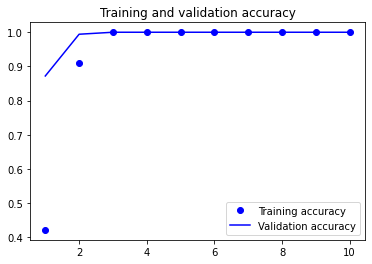

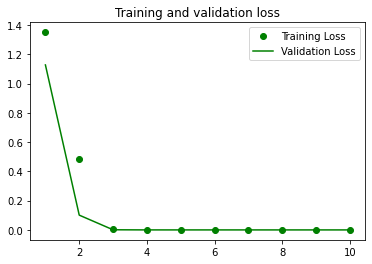

In [12]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

x_range = range(1, epochs + 1)

plt.plot(x_range, acc, 'bo', label='Training accuracy')
plt.plot(x_range, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(x_range, loss, 'go', label='Training Loss')
plt.plot(x_range, val_loss, 'g', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [13]:
from sklearn.metrics import f1_score

validation_original = validation_generator.classes
pred = model.predict(validation_generator)
pred_array = np.argmax(pred, axis=1)

f1_score(validation_generator.classes, pred_array, average='weighted')

0.2558139534883721